In [1]:
from MLimports2 import *
exec(MLimports())


from copy import copy
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
from scipy import stats
from sklearn import metrics,neighbors,preprocessing
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression as LR
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error as mse
from

In [2]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true = y_true[np.nonzero(y_true)] # avoid incidents with zero duration
    y_pred = y_pred[np.nonzero(y_true)]
    return abs(np.mean(np.abs((y_true - y_pred) / y_true)) * 100)

# def smape(A, F):
#     return 100/len(A) * np.sum( np.abs(F - A) / ((np.abs(A) + np.abs(F))/2.0) )

#second implementation
def smape(A, F):
    A = np.abs(np.mean(A)-F)
    B = np.abs(np.mean(A)) + np.abs(F)
    return 100.0*np.sum(A/B)/len(A)

from scipy import stats
def r2abs(yt,yp):
    A = np.sum(np.power(yp - yt, 2))
    B = np.sum(np.power(yt - np.mean(yt), 2))
    return abs(1-A/B)

def r2opt(yt,yp):
    A = np.sum(np.power(yp - yt, 2))
    B = np.sum(np.power(yt - np.mean(yt), 2))
    return A/B

def r2(yt,yp):
    A = np.sum(np.power(yp - yt, 2))
    B = np.sum(np.power(yt - np.mean(yt), 2))
    return 1-A/B

def mse(yt,yp):
    return mean_squared_error(yt,yp)

def rmse(yt,yp):
    return np.sqrt(mean_squared_error(yt,yp))


#
def csmape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true = y_true[np.nonzero(y_true)] # avoid incidents with zero duration
    y_pred = y_pred[np.nonzero(y_true)]
    CS = (np.abs(y_true - y_pred) > (y_true/6))
    y_pred[CS] -= y_true[CS]/6
    y_pred[~CS] = 0 
    return np.mean(CS*np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
import lightgbm as lgb

In [4]:
RESULTS=[]

In [7]:
# search = RandomizedSearchCV(estimator = lgb.LGBMRegressor(),
#                    param_distributions={
#             'learning_rate' : np.linspace(0,0.5,100), 
#             'n_estimators' : range(20,300,1),
#             'num_leaves' : range(2,128,1),
#             'max_depth':range(1,10,1), ##MAR: start at 3 
#             'subsample':np.linspace(0.1,1,100)
#         },
#                    n_iter=800,
#                    scoring=make_scorer(mape, greater_is_better=False),
#                    n_jobs=32, ## MAR: used to be 1
#                    cv = 10,
#                    verbose = 1
#                        )
# search.fit(X, np.log1p(Y))

In [8]:
from sklearn.neighbors import KNeighborsRegressor

In [9]:
OPTIMIZER = []
OPTIMIZER.append({'name':'XGB','instance':XGBClassifier,'param':{
            'learning_rate' : np.linspace(0.0001,0.9999,1000), 
            'n_estimators' : range(20,200,1),
            'max_depth':range(2,15,1), ##MAR: start at 3 
            'subsample':np.linspace(0.01,0.99,1000)
        }})

# OPTIMIZER.append({'name':'XGB2','instance':XGBRegressor,'param':{
#             'learning_rate' : np.linspace(0,0.5,50), 
#             'n_estimators' : range(20,200,1),
#             'max_depth':range(1,15,1), ##MAR: start at 3 
#             'subsample':[0.6,0.7,0.75,0.8,0.85,0.9,0.95,1.0]
#         }})
OPTIMIZER.append({'name':'KNN','instance':KNeighborsClassifier,'param':{
            'n_neighbors' : range(2,100), 
            'weights' : ['uniform','distance']
        }})

# OPTIMIZER.append({'name':'LGBM','instance':lgb.LGBMClassifier,'param':{
#             'learning_rate' : [0.0001, 0.001, 0.1], 
#             'n_estimators' : range(20,200,1),
#             'num_leaves' : range(10,100,1),
#             'max_depth':range(1,15,1), ##MAR: start at 3 
#             'subsample':[0.6,0.7,0.75,0.8,0.85,0.9,0.95,1.0]
#         }})

# OPTIMIZER.append({'name':'ELM','instance':ELMRegressor,'param':{
#             'n_hidden' : range(2,100), 
#             'alpha' : np.linspace(0,1,20),
#             'rbf_width':np.linspace(0,1,20)
#         }})

OPTIMIZER.append({'name':'GBDT','instance': GradientBoostingClassifier, 'param':{
    'learning_rate' : np.linspace(0.0001,0.9999,1000), 
    'n_estimators' : range(20,200,1),
    'max_depth':range(3,15,1), ##MAR: start at 3 
    'subsample':np.linspace(0.01,0.99,1000)
}})

OPTIMIZER.append({'name':'LR','instance': LogisticRegression, 'param':{
    'C':np.linspace(0.00001,0.999999,1000),
    'solver': ['newton-cg','lbfgs','sag','saga','liblinear'],
    'fit_intercept':[True,False]
}})

OPTIMIZER.append({'name':'RF','instance': RandomForestClassifier, 'param':{
    'n_estimators' : range(20,200,1),
    'max_depth':range(2,15,1), ##MAR: start at 3 
}})

In [10]:
RESULTS = []

In [11]:
METRIC = []
METRIC.append({'name':'F1','instance':f1_score})
# METRIC.append({'name':'Precision','instance':precision_score})
# METRIC.append({'name':'Recall','instance':recall_score})
# METRIC.append({'name':'Accuracy','instance':accuracy_score})

In [12]:
def EVAL2(REG,MET,TH):
    global RESULTS,X,Y
    from sklearn.model_selection import KFold
    import multiprocessing
    
    search = RandomizedSearchCV(estimator = REG['instance'](),
                       param_distributions=REG['param'],
                       n_iter=100,
                       scoring=make_scorer(MET['instance'], greater_is_better=True),
                       n_jobs=multiprocessing.cpu_count(), ## MAR: used to be 1
                       cv = 10,
                       verbose = 1
                           )
    search.fit(X, Y)
    reg = REG['instance'](**search.best_params_)
    
    
    
    FOLDS=10
    ATTEMPTS=1
    kf = KFold(n_splits=FOLDS,shuffle=True)
    kf.get_n_splits(X)

    SCOREF1=[]
    SCOREAC=[]
    SCOREPR=[]
    SCORERE=[]
    
    
    import tqdm
    for A in range(ATTEMPTS):
        for train_index, test_index in tqdm.tqdm(kf.split(X)):
            Xtr, Xte = X.iloc[train_index], X.iloc[test_index]
            Ytr, Yte = Y[train_index], Y[test_index]
            evaluation = [( Xtr,Ytr ), ( Xte, Yte)]

            reg.fit(Xtr, Ytr)

            pred = reg.predict(Xte)

            PRED = np.array(pred).ravel()
            SCOREF1.append(f1_score(Yte, PRED))
            SCOREAC.append(accuracy_score(Yte, PRED))
            SCOREPR.append(precision_score(Yte,PRED))
            SCORERE.append(recall_score(Yte,PRED))

            
    RESULTS.append({'Optimizer': REG['name'],
      'Training': MET['name'],
      'f1': np.array(SCOREF1).mean(),
      'recall': np.array(SCORERE).mean(), 'precision': np.array(SCOREPR).mean(),
      'accuracy': np.array(SCOREAC).mean(),'folding':'KF','threshold':TH})

    


In [18]:
X,Y = getBFS(part=[0,-1])

/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


In [19]:
Y[Y<40] = 0
Y[Y>=40] = 1

In [20]:
Y

array([0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,

In [33]:
RESULTS = []

for TH in list(range(10)):
    print(TH)
    X,Y = getMBFS(part=[0,-1])
    Y=np.array(sorted(Y))
    X = X[Y>TH]
    Y = Y[Y>TH]
    
    Y[Y<40] = 0
    Y[Y>=40] = 1
# Y = np.log1p(Y)
    from sklearn import preprocessing

    vals = X.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(vals)
    X = pd.DataFrame(x_scaled)

    for O in OPTIMIZER:
        print(O['name'])
        for M in METRIC:
            print(M['name'])
            print('lpo')
            EVAL2(O,M,TH)
    #         EVAL_LOOCV(O,M)
            print('kfold')


0


/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


XGB
F1
lpo
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:   20.7s
[Parallel(n_jobs=56)]: Done 338 tasks      | elapsed:   23.1s
[Parallel(n_jobs=56)]: Done 688 tasks      | elapsed:   30.7s
[Parallel(n_jobs=56)]: Done 1000 out of 1000 | elapsed:   38.3s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
10it [00:06,  1.53it/s]
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
KNN
F1
lpo
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    1.0s
[Parallel(n_jobs=56)]: Done 338 tasks      | elapsed:    2.4s
[Parallel(n_jobs=56)]: Done 688 tasks      | elapsed:    5.2s
[Parallel(n_jobs=56)]: Done 1000 out of 1000 | elapsed:    7.6s finished
10it [00:00, 15.42it/s]
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
GBDT
F1
lpo
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    2.1s
[Parallel(n_jobs=56)]: Done 442 tasks      | elapsed:    5.5s
[Parallel(n_jobs=56)]: Done 792 tasks      | elapsed:   11.1s
[Parallel(n_jobs=56)]: Done 1000 out of 1000 | elapsed:   13.9s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
10it [00:07,  1.38it/s]
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
LR
F1
lpo
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.7s
[Parallel(n_jobs=56)]: Done 1000 out of 1000 | elapsed:    2.1s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
10it [00:00, 38.14it/s]
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
RF
F1
lpo
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    1.4s
[Parallel(n_jobs=56)]: Done 338 tasks      | elapsed:    4.8s
[Parallel(n_jobs=56)]: Done 688 tasks      | elapsed:    9.8s
[Parallel(n_jobs=56)]: Done 1000 out of 1000 | elapsed:   12.7s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
10it [00:01,  9.62it/s]
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22

kfold
1
XGB
F1
lpo
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    1.6s
[Parallel(n_jobs=56)]: Done 338 tasks      | elapsed:    7.8s
[Parallel(n_jobs=56)]: Done 688 tasks      | elapsed:   13.5s
[Parallel(n_jobs=56)]: Done 1000 out of 1000 | elapsed:   17.6s finished
10it [00:06,  1.52it/s]
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
KNN
F1
lpo
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    1.3s
[Parallel(n_jobs=56)]: Done 564 tasks      | elapsed:    3.0s
[Parallel(n_jobs=56)]: Done 1000 out of 1000 | elapsed:    5.3s finished
10it [00:00, 17.62it/s]
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
GBDT
F1
lpo
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    1.3s
[Parallel(n_jobs=56)]: Done 338 tasks      | elapsed:    4.1s
[Parallel(n_jobs=56)]: Done 688 tasks      | elapsed:    8.1s
[Parallel(n_jobs=56)]: Done 1000 out of 1000 | elapsed:   12.9s finished
10it [00:03,  3.09it/s]
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
LR
F1
lpo
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.4s
[Parallel(n_jobs=56)]: Done 1000 out of 1000 | elapsed:    1.7s finished
10it [00:00, 41.19it/s]
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
RF
F1
lpo
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    1.2s
[Parallel(n_jobs=56)]: Done 497 tasks      | elapsed:    7.7s
[Parallel(n_jobs=56)]: Done 847 tasks      | elapsed:   12.5s
[Parallel(n_jobs=56)]: Done 1000 out of 1000 | elapsed:   14.2s finished
10it [00:00, 12.77it/s]
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


kfold
2
XGB
F1
lpo
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    2.2s
[Parallel(n_jobs=56)]: Done 338 tasks      | elapsed:    7.8s
[Parallel(n_jobs=56)]: Done 688 tasks      | elapsed:   13.7s
[Parallel(n_jobs=56)]: Done 1000 out of 1000 | elapsed:   19.4s finished
10it [00:05,  1.79it/s]
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
KNN
F1
lpo
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.9s
[Parallel(n_jobs=56)]: Done 564 tasks      | elapsed:    2.6s
[Parallel(n_jobs=56)]: Done 1000 out of 1000 | elapsed:    4.6s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
10it [00:00, 21.05it/s]
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
GBDT
F1
lpo
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    1.8s
[Parallel(n_jobs=56)]: Done 736 tasks      | elapsed:    9.9s
[Parallel(n_jobs=56)]: Done 1000 out of 1000 | elapsed:   13.7s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
10it [00:02,  3.41it/s]
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
LR
F1
lpo
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.4s
[Parallel(n_jobs=56)]: Done 1000 out of 1000 | elapsed:    2.2s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
10it [00:00, 35.35it/s]
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
RF
F1
lpo
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.9s
[Parallel(n_jobs=56)]: Done 485 tasks      | elapsed:    7.4s
[Parallel(n_jobs=56)]: Done 835 tasks      | elapsed:   11.9s
[Parallel(n_jobs=56)]: Done 1000 out of 1000 | elapsed:   13.5s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
10it [00:00, 12.03it/s]
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22

kfold
3
XGB
F1
lpo
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    2.1s
[Parallel(n_jobs=56)]: Done 450 tasks      | elapsed:    7.2s
[Parallel(n_jobs=56)]: Done 800 tasks      | elapsed:   12.8s
[Parallel(n_jobs=56)]: Done 1000 out of 1000 | elapsed:   16.8s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
10it [00:11,  1.15s/it]
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
KNN
F1
lpo
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    1.2s
[Parallel(n_jobs=56)]: Done 338 tasks      | elapsed:    2.3s
[Parallel(n_jobs=56)]: Done 688 tasks      | elapsed:    4.3s
[Parallel(n_jobs=56)]: Done 1000 out of 1000 | elapsed:    6.7s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
10it [00:00, 23.09it/s]
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
GBDT
F1
lpo
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    1.0s
[Parallel(n_jobs=56)]: Done 527 tasks      | elapsed:    8.1s
[Parallel(n_jobs=56)]: Done 877 tasks      | elapsed:   13.2s
[Parallel(n_jobs=56)]: Done 1000 out of 1000 | elapsed:   14.2s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
10it [00:03,  2.70it/s]
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
LR
F1
lpo
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.6s
[Parallel(n_jobs=56)]: Done 1000 out of 1000 | elapsed:    1.9s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
10it [00:00, 44.64it/s]
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
RF
F1
lpo
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    2.2s
[Parallel(n_jobs=56)]: Done 338 tasks      | elapsed:    5.4s
[Parallel(n_jobs=56)]: Done 688 tasks      | elapsed:   10.5s
[Parallel(n_jobs=56)]: Done 1000 out of 1000 | elapsed:   14.6s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
10it [00:00, 17.41it/s]
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22

kfold
4
XGB
F1
lpo
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    1.1s
[Parallel(n_jobs=56)]: Done 466 tasks      | elapsed:    8.3s
[Parallel(n_jobs=56)]: Done 816 tasks      | elapsed:   12.5s
[Parallel(n_jobs=56)]: Done 1000 out of 1000 | elapsed:   14.7s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
10it [00:06,  1.50it/s]
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
KNN
F1
lpo
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.8s
[Parallel(n_jobs=56)]: Done 564 tasks      | elapsed:    2.6s
[Parallel(n_jobs=56)]: Done 1000 out of 1000 | elapsed:    4.6s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
10it [00:00, 27.16it/s]
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
GBDT
F1
lpo
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    3.0s
[Parallel(n_jobs=56)]: Done 338 tasks      | elapsed:    5.2s
[Parallel(n_jobs=56)]: Done 688 tasks      | elapsed:   14.8s
[Parallel(n_jobs=56)]: Done 1000 out of 1000 | elapsed:   20.2s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
10it [00:03,  3.09it/s]
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
LR
F1
lpo
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.4s
[Parallel(n_jobs=56)]: Done 1000 out of 1000 | elapsed:    2.1s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
10it [00:00, 43.44it/s]
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
RF
F1
lpo
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.9s
[Parallel(n_jobs=56)]: Done 338 tasks      | elapsed:    4.2s
[Parallel(n_jobs=56)]: Done 688 tasks      | elapsed:    9.5s
[Parallel(n_jobs=56)]: Done 1000 out of 1000 | elapsed:   13.6s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
10it [00:01,  5.81it/s]
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22

kfold
5
XGB
F1
lpo
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    1.0s
[Parallel(n_jobs=56)]: Done 511 tasks      | elapsed:    6.6s
[Parallel(n_jobs=56)]: Done 861 tasks      | elapsed:   11.3s
[Parallel(n_jobs=56)]: Done 1000 out of 1000 | elapsed:   12.8s finished
10it [00:02,  4.82it/s]
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
KNN
F1
lpo
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.5s
[Parallel(n_jobs=56)]: Done 564 tasks      | elapsed:    1.6s
[Parallel(n_jobs=56)]: Done 1000 out of 1000 | elapsed:    2.4s finished
10it [00:00, 23.84it/s]
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
GBDT
F1
lpo
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.7s
[Parallel(n_jobs=56)]: Done 564 tasks      | elapsed:    3.4s
[Parallel(n_jobs=56)]: Done 1000 out of 1000 | elapsed:    6.3s finished
10it [00:02,  3.34it/s]
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
LR
F1
lpo
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.3s
[Parallel(n_jobs=56)]: Done 1000 out of 1000 | elapsed:    1.5s finished
10it [00:00, 60.83it/s]
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
RF
F1
lpo
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.6s
[Parallel(n_jobs=56)]: Done 564 tasks      | elapsed:    3.1s
[Parallel(n_jobs=56)]: Done 1000 out of 1000 | elapsed:    5.4s finished
10it [00:00, 12.24it/s]
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


kfold
6
XGB
F1
lpo
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.8s
[Parallel(n_jobs=56)]: Done 564 tasks      | elapsed:    4.0s
[Parallel(n_jobs=56)]: Done 1000 out of 1000 | elapsed:    6.6s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
10it [00:01,  5.36it/s]
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
KNN
F1
lpo
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.5s
[Parallel(n_jobs=56)]: Done 1000 out of 1000 | elapsed:    2.2s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
10it [00:00, 25.79it/s]
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
GBDT
F1
lpo
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.8s
[Parallel(n_jobs=56)]: Done 564 tasks      | elapsed:    3.2s
[Parallel(n_jobs=56)]: Done 1000 out of 1000 | elapsed:    5.5s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
10it [00:02,  4.24it/s]
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
LR
F1
lpo
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.3s
[Parallel(n_jobs=56)]: Done 1000 out of 1000 | elapsed:    1.1s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
10it [00:00, 58.52it/s]
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
RF
F1
lpo
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.7s
[Parallel(n_jobs=56)]: Done 564 tasks      | elapsed:    3.7s
[Parallel(n_jobs=56)]: Done 1000 out of 1000 | elapsed:    5.6s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
10it [00:00, 19.95it/s]
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_functio

kfold
7
XGB
F1
lpo
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.9s
[Parallel(n_jobs=56)]: Done 338 tasks      | elapsed:    2.4s
[Parallel(n_jobs=56)]: Done 688 tasks      | elapsed:    4.4s
[Parallel(n_jobs=56)]: Done 1000 out of 1000 | elapsed:    6.0s finished
10it [00:02,  3.65it/s]
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
KNN
F1
lpo
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.5s
[Parallel(n_jobs=56)]: Done 564 tasks      | elapsed:    1.5s
[Parallel(n_jobs=56)]: Done 1000 out of 1000 | elapsed:    2.2s finished
10it [00:00, 21.62it/s]
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
GBDT
F1
lpo
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.6s
[Parallel(n_jobs=56)]: Done 564 tasks      | elapsed:    3.2s
[Parallel(n_jobs=56)]: Done 1000 out of 1000 | elapsed:    6.2s finished
10it [00:03,  3.15it/s]
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
LR
F1
lpo
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.3s
[Parallel(n_jobs=56)]: Done 1000 out of 1000 | elapsed:    1.1s finished
10it [00:00, 59.64it/s]
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
RF
F1
lpo
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.6s
[Parallel(n_jobs=56)]: Done 564 tasks      | elapsed:    3.1s
[Parallel(n_jobs=56)]: Done 1000 out of 1000 | elapsed:    5.4s finished
10it [00:01,  7.70it/s]
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


kfold
8
XGB
F1
lpo
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.6s
[Parallel(n_jobs=56)]: Done 564 tasks      | elapsed:    3.5s
[Parallel(n_jobs=56)]: Done 1000 out of 1000 | elapsed:    6.1s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
10it [00:00, 21.34it/s]
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
KNN
F1
lpo
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.5s
[Parallel(n_jobs=56)]: Done 564 tasks      | elapsed:    1.6s
[Parallel(n_jobs=56)]: Done 1000 out of 1000 | elapsed:    2.5s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
10it [00:00, 15.05it/s]
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
GBDT
F1
lpo
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.8s
[Parallel(n_jobs=56)]: Done 564 tasks      | elapsed:    3.3s
[Parallel(n_jobs=56)]: Done 1000 out of 1000 | elapsed:    6.2s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
10it [00:03,  3.26it/s]
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
LR
F1
lpo
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.4s
[Parallel(n_jobs=56)]: Done 1000 out of 1000 | elapsed:    1.4s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
10it [00:00, 46.78it/s]
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
RF
F1
lpo
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.8s
[Parallel(n_jobs=56)]: Done 338 tasks      | elapsed:    2.5s
[Parallel(n_jobs=56)]: Done 688 tasks      | elapsed:    5.7s
[Parallel(n_jobs=56)]: Done 1000 out of 1000 | elapsed:    8.6s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
10it [00:01,  5.78it/s]
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22

kfold
9
XGB
F1
lpo
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    2.3s
[Parallel(n_jobs=56)]: Done 338 tasks      | elapsed:    7.8s
[Parallel(n_jobs=56)]: Done 688 tasks      | elapsed:   12.2s
[Parallel(n_jobs=56)]: Done 1000 out of 1000 | elapsed:   16.7s finished
10it [00:11,  1.19s/it]
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
KNN
F1
lpo
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    1.7s
[Parallel(n_jobs=56)]: Done 450 tasks      | elapsed:    6.6s
[Parallel(n_jobs=56)]: Done 800 tasks      | elapsed:    9.2s
[Parallel(n_jobs=56)]: Done 1000 out of 1000 | elapsed:   10.3s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
10it [00:00, 15.19it/s]
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
GBDT
F1
lpo
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.9s
[Parallel(n_jobs=56)]: Done 564 tasks      | elapsed:    5.4s
[Parallel(n_jobs=56)]: Done 1000 out of 1000 | elapsed:   15.6s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
10it [00:01,  5.59it/s]
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
LR
F1
lpo
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.5s
[Parallel(n_jobs=56)]: Done 1000 out of 1000 | elapsed:    2.0s finished
10it [00:00, 84.36it/s]
[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.


kfold
RF
F1
lpo
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    1.3s
[Parallel(n_jobs=56)]: Done 338 tasks      | elapsed:    5.9s
[Parallel(n_jobs=56)]: Done 688 tasks      | elapsed:   15.0s
[Parallel(n_jobs=56)]: Done 1000 out of 1000 | elapsed:   23.7s finished
10it [00:01,  5.78it/s]

kfold


In [34]:
RESULTS

[{'Optimizer': 'XGB',
  'Training': 'F1',
  'f1': 0.983076088850839,
  'recall': 1.0,
  'precision': 0.9667532459703947,
  'accuracy': 0.984767466681516,
  'folding': 'KF',
  'threshold': 0},
 {'Optimizer': 'KNN',
  'Training': 'F1',
  'f1': 0.936034648167451,
  'recall': 0.9129760030949038,
  'precision': 0.9603750202647239,
  'accuracy': 0.9447089505141626,
  'folding': 'KF',
  'threshold': 0},
 {'Optimizer': 'GBDT',
  'Training': 'F1',
  'f1': 1.0,
  'recall': 1.0,
  'precision': 1.0,
  'accuracy': 1.0,
  'folding': 'KF',
  'threshold': 0},
 {'Optimizer': 'LR',
  'Training': 'F1',
  'f1': 0.9675380445736576,
  'recall': 0.9717903500728958,
  'precision': 0.963404955125695,
  'accuracy': 0.9710600196755393,
  'folding': 'KF',
  'threshold': 0},
 {'Optimizer': 'RF',
  'Training': 'F1',
  'f1': 0.9842303913099648,
  'recall': 0.9993103611716749,
  'precision': 0.9696936826316485,
  'accuracy': 0.9858317555778298,
  'folding': 'KF',
  'threshold': 0},
 {'Optimizer': 'XGB',
  'Training':

In [35]:
RES = pd.DataFrame(RESULTS)
RES

,Optimizer,Training,f1,recall,precision,accuracy,folding,threshold
0,XGB,F1,0.983076,1.000000,0.966753,0.984767,KF,0
1,KNN,F1,0.936035,0.912976,0.960375,0.944709,KF,0
2,GBDT,F1,1.000000,1.000000,1.000000,1.000000,KF,0
3,LR,F1,0.967538,0.971790,0.963405,0.971060,KF,0
4,RF,F1,0.984230,0.999310,0.969694,0.985832,KF,0
5,XGB,F1,0.978783,0.988425,0.969440,0.979475,KF,1
6,KNN,F1,0.938767,0.917447,0.961415,0.943021,KF,1
7,GBDT,F1,1.000000,1.000000,1.000000,1.000000,KF,1
8,LR,F1,0.968595,0.977308,0.960255,0.969787,KF,1
9,RF,F1,0.983532,0.999639,0.967990,0.984072,KF,1


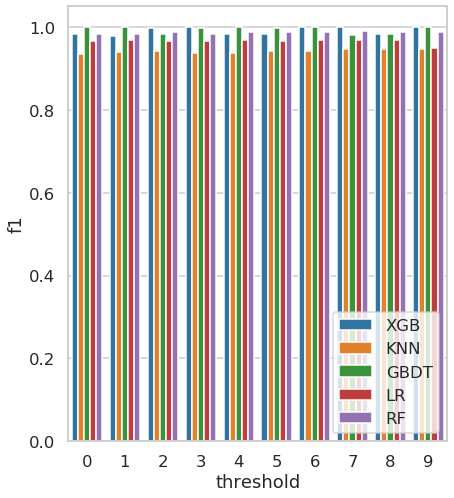

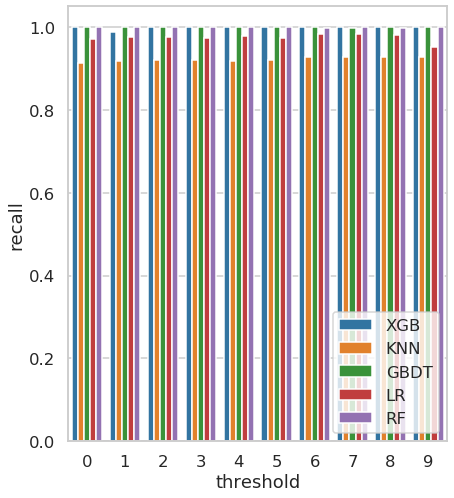

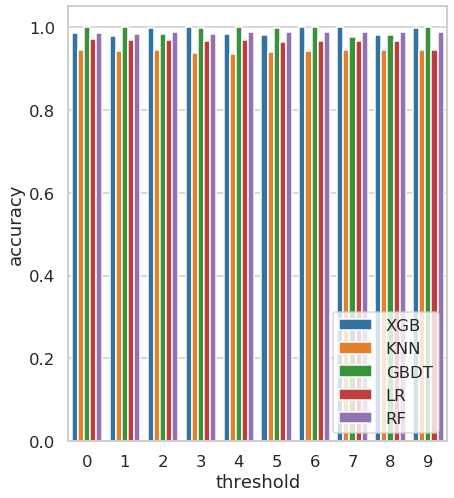

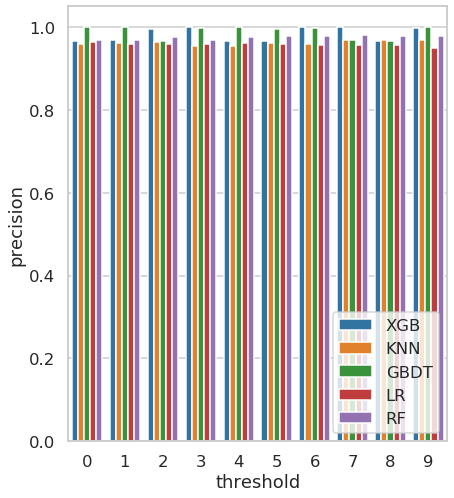

In [36]:
import seaborn as sns
sns.set_style("ticks")
sns.set_style("whitegrid")
sns.set_context("talk")

for M in ['f1','recall','accuracy','precision']:
    plt.figure(figsize=(6.8,8))
    ax = sns.barplot(x="threshold", y=M,hue='Optimizer', data=RES)
    plt.setp(ax.get_legend().get_texts(), fontsize='13')
    plt.legend(loc='lower right')
    plt.show()

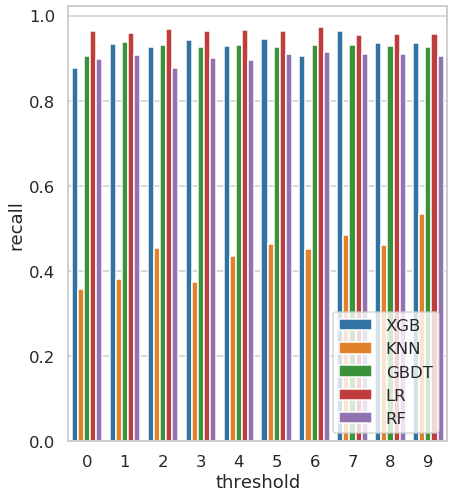

In [29]:
import seaborn as sns
sns.set_style("ticks")
sns.set_style("whitegrid")
sns.set_context("talk")

plt.figure(figsize=(6.8,8))
ax = sns.barplot(x="threshold", y='recall',hue='Optimizer', data=RES)
plt.setp(ax.get_legend().get_texts(), fontsize='13')
plt.legend(loc='lower right')

In [17]:
RES['rmse'] = RES['mse'].apply(lambda v: np.sqrt(v))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

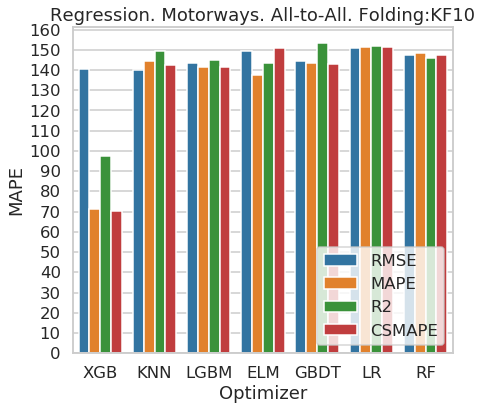

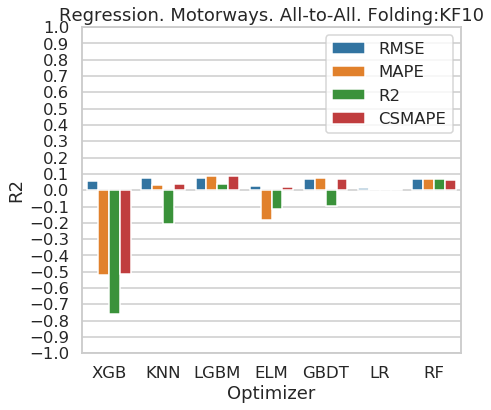

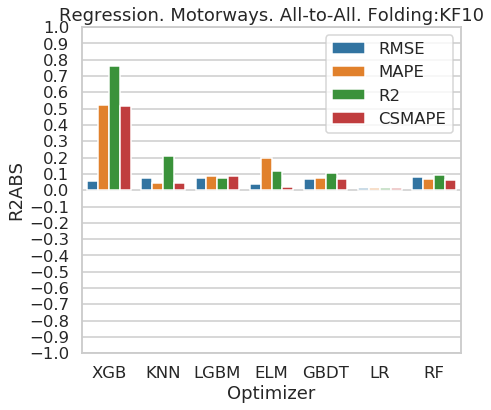

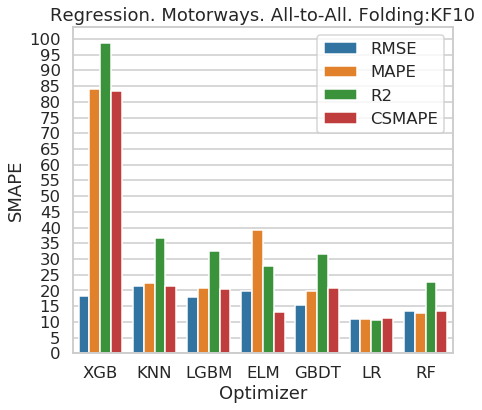

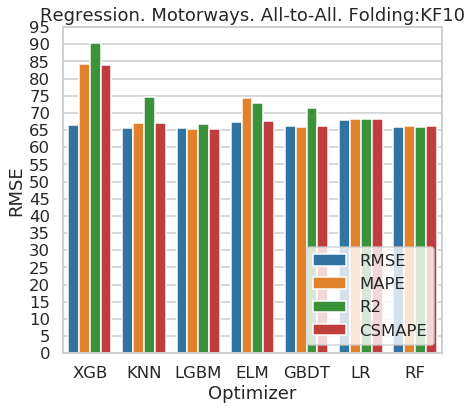

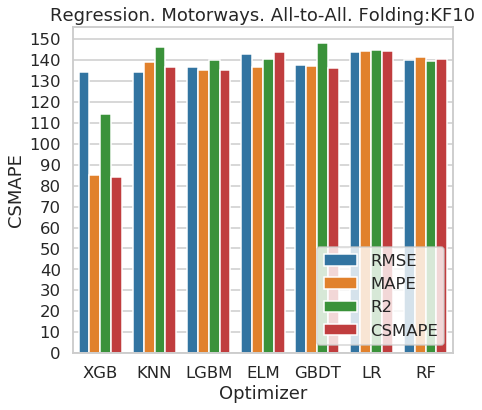

In [19]:
for f in ['KF10']:
    for M in ['mape','r2','r2abs','smape','rmse','csmape']:

        import seaborn as sns
        sns.set_style("ticks")
        sns.set_style("whitegrid")
        sns.set_context("talk")

        plt.figure(figsize=(6.8,6))
        ax = sns.barplot(x="Optimizer", y=M,hue='Training', data=RES[RES.folding==f])
        plt.setp(ax.get_legend().get_texts(), fontsize='13')

        plt.title('Regression. Motorways. All-to-All. Folding:{}'.format(f))
        plt.ylabel(M.upper())

        if M=='r2' or M=='r2abs':
            plt.ylim(0,1)
            plt.yticks(np.arange(-1,1.1,0.1))

        elif M=='mape' or M=='csmape':
            plt.yticks(np.round(np.arange(0,RES[RES.folding==f][M].max()+10,10)))
        else:
            plt.yticks(np.round(np.arange(0,RES[RES.folding==f][M].max()+5,5)))

        if M=='r2' or M=='smape' or M=='r2abs':
            plt.legend(loc='upper right')
        else:
            plt.legend(loc='lower right')
    #     plt.show()
        plt.savefig('regression_allM_kf_ext_art_{}_{}.eps'.format(M,f),format='eps')
        plt.savefig('regression_allM_kf_ext_art_{}_{}.png'.format(M,f),format='png')

In [19]:
!tar -cf foo.tar regression_all_loocv*.eps *.png

/usr/bin/sh: 1: 7z: not found


In [2]:
def CHECK(REG,X,Y,M):
    
    METRIC = M
    
    from sklearn.model_selection import KFold
    
    FOLDS=10
    ATTEMPTS=1
    kf = KFold(n_splits=FOLDS)
    
    SCORE=0.0
    for A in range(ATTEMPTS):
        for train_index, test_index in kf.split(X):
            Xtr, Xte = X[train_index], X[test_index]
            Ytr, Yte = Y[train_index], Y[test_index]
            evaluation = [( Xtr,Ytr ), ( Xte, Yte)]

#             if log:
#                 Ytr=np.log1p(Ytr)
            rsearch01 = RandomizedSearchCV(estimator = REG,
                               param_distributions=param_test11,
                               n_iter=100,
                               scoring=make_scorer(METRIC, greater_is_better=False),
                               n_jobs=multiprocessing.cpu_count(), ## MAR: used to be 1
                               cv = 5,
                               verbose = 1
                                   )
            REG.fit(Xtr, Ytr)

            pred = REG.predict(Xte)

#             if log:
#                 pred=np.expm1(pred)

            SCORE += METRIC(Yte, pred)

    SCORE=SCORE/(FOLDS*ATTEMPTS)
    
    return SCORE

# Random search using MAPE

In [3]:

def fix(inhash):
    for k in inhash.keys():
        if k in ['max_depth','min_child_weight','n_estimators','reg_alpha','min_samples_split']:
            inhash[k] = int(inhash[k])

            
def _eval(optimizer,metric,space,X,Y,log=False):
        from sklearn.model_selection import KFold
        REG=optimizer(**space)

        FOLDS=5
        ATTEMPTS=1
        kf = KFold(n_splits=FOLDS)


        SCORE=0.0
        for A in range(ATTEMPTS):
            for train_index, test_index in kf.split(X):
                Xtr, Xte = X[train_index], X[test_index]
                Ytr, Yte = Y[train_index], Y[test_index]
                evaluation = [( Xtr,Ytr ), ( Xte, Yte)]
    #             print(np.count_nonzero(~np.isnan(Yte)))
                if log:
                    Ytr=np.log1p(Ytr)

                REG.fit(Xtr, Ytr)

                pred = REG.predict(Xte)

                if log:
                    pred=np.expm1(pred)

                SCORE += metric(Yte, pred)
    #             print(Yte,SCORE)

        SCORE=SCORE/(FOLDS*ATTEMPTS)

        return {'loss':SCORE, 'status': STATUS_OK }
    
    
class Experiment:
    def __init__(self):
        pass
    
    def set_XY(self,X,Y):
        import copy
        self.X = np.array(copy.deepcopy(X))
        self.Y = np.array(copy.deepcopy(Y))
    
    def set_hyperspace(self,space):
        self.space = space
        
    def set_optimizer(self,opt):
        self.optimizer = opt
        
    def set_hypermetric(self,metric):
        self.hypermetric = metric
        
        
    def optimize(self,evals=5):
        
        def tmp(sp):
#             print('tmp',sp)
            return _eval(self.optimizer, self.hypermetric, sp, self.X,self.Y,True)
        
        trials = Trials()
        best = fmin(fn=tmp,
            space=self.space,
            algo=tpe.rand.suggest,
            max_evals=evals,
            trials=trials)
        fix(best)
        self.best = best
#         best['objective'] = 'reg:squarederror'
        print(best)
    
    def evaluate(self,metrics,log=False,X=None,Y=None):
        
        if X is None:
            X=self.X
            Y=self.Y
        else:
            print('evaluate using input X,Y')
        
        from sklearn.model_selection import KFold

        FOLDS=10
        ATTEMPTS=1
        kf = KFold(n_splits=FOLDS)

        SCORE={}
        
        for k in metrics:
            SCORE[k.__name__] = 0.0
        
        for A in range(ATTEMPTS):
            
            REG=self.optimizer(**self.best)
            print(REG)
            
            for train_index, test_index in kf.split(X):
                Xtr, Xte = X[train_index], X[test_index]
                Ytr, Yte = Y[train_index], Y[test_index]
                evaluation = [( Xtr,Ytr ), ( Xte, Yte)]

    #             if log:
    #                 Ytr=np.log1p(Ytr)

                REG.fit(Xtr, Ytr)

                pred = REG.predict(Xte)

    #             if log:
    #                 pred=np.expm1(pred)
                for k in metrics:
            
                    SCORE[k.__name__] += k(Yte, pred)

#         SCORE=SCORE/(FOLDS*ATTEMPTS)
        
        print(SCORE)
        for k in metrics:
            SCORE[k.__name__] /= (FOLDS*ATTEMPTS)
        print(SCORE)
        
        
        
        res = {'Optimizer':self.optimizer.__name__, 'Training':self.hypermetric.__name__}
        
        if res['Optimizer']=='GradientBoostingRegressor':
            res['Optimizer'] = 'GBDT'
            
        if res['Optimizer']=='RandomForestRegressor':
            res['Optimizer'] = 'RF'
            
        if res['Optimizer']=='XGBRegressor':
            res['Optimizer'] = 'XGBoost'
        
        if res['Optimizer']=='Ridge':
            res['Optimizer'] = 'LR'
        
        print(res)
        for k in metrics:
            res[k.__name__] = SCORE[k.__name__]
            
        
        #cosmetic change
        if 'mean_square_error'in res.keys():
            res['mse'] = res['mean_squared_error']
            del res['mean_squared_error']
        
        
        return res
    
#     def hypereval(space):
#         return _eval(self.optimizer, self.hypermetric,space)

In [4]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true = y_true[np.nonzero(y_true)] # avoid incidents with zero duration
    y_pred = y_pred[np.nonzero(y_true)]
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(A, F):
    return 100/len(A) * np.sum( np.abs(F - A) / ((np.abs(A) + np.abs(F))/2.0) )

from scipy import stats
def r2(yt,yp):
    A = np.sum(np.power(yp - yt, 2))
    B = np.sum(np.power(yt - np.mean(yt), 2))
    return A/B

def mse(yt,yp):
    return mean_squared_error(yt,yp)

In [11]:
RESULTS = []

METRICS = [mape,smape,r2,mse]

In [12]:
for M in METRICS:
    
    xg = Experiment()
    
    xg.set_hyperspace({'max_depth': scope.int(hp.quniform("max_depth", 2, 20, 1)),
        'reg_alpha' : scope.int(hp.quniform('reg_alpha', 40,180,1)),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'subsample' : hp.uniform('subsample', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': scope.int(hp.quniform('n_estimators', 40,180,1)),
         'objective':'reg:squarederror'
    })
    
    xg.set_hypermetric(M)
    xg.set_optimizer(XGBRegressor)
    
    X,Y = getBFS(part=[5,45])
    xg.set_XY(X,Y)
    xg.optimize(40)
    
    X,Y = getBFS(part=[45,-1])
    RESULTS.append(xg.evaluate(METRICS,log=False,X=np.array(X),Y=np.array(Y)))
    print(RESULTS[-1])

100%|██████████| 40/40 [00:05<00:00,  7.43trial/s, best loss: 50.01285204189615]
{'colsample_bytree': 0.7218616411548953, 'max_depth': 19, 'min_child_weight': 3, 'n_estimators': 53, 'reg_alpha': 89, 'reg_lambda': 0.5829992047366002, 'subsample': 0.857949468337549}
evaluate using input X,Y
XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=0.7218616411548953,
             gamma=None, gpu_id=None, importance_type='gain',
             interaction_constraints=None, learning_rate=None,
             max_delta_step=None, max_depth=19, min_child_weight=3, missing=nan,
             monotone_constraints=None, n_estimators=53, n_jobs=None,
             num_parallel_tree=None, random_state=None, reg_alpha=89,
             reg_lambda=0.5829992047366002, scale_pos_weight=None,
             subsample=0.857949468337549, tree_method=None,
             validate_parameters=None, verbosity=None)
{'mape': 717.166643156555, 'smape': 581.0

In [330]:
# RESULTS

In [14]:
for M in METRICS:
    gbdt = Experiment()
    
    gbdt.set_hyperspace({'max_depth': scope.int(hp.quniform("max_depth", 2, 20, 1)),##
        'alpha' : hp.uniform('alpha', 0.0,1.0),##
#         'loss' : hp.choice('loss', ['ls', 'lad', 'huber', 'quantile']),##
        'max_features' : hp.uniform('max_features', 0.5,1),##
        'subsample' : hp.uniform('subsample', 0.5,1),##
        'min_samples_split' : scope.int(hp.quniform('min_samples_split', 2, 31, 1)),##
        'n_estimators': scope.int(hp.quniform('n_estimators', 40,180,1))##
    })
    
    gbdt.set_hypermetric(M)
    gbdt.set_optimizer(GradientBoostingRegressor)
    X,Y = getBFS(part=[5,45])
    gbdt.set_XY(X,Y)
    gbdt.optimize(40)
    X,Y = getBFS(part=[45,-1])
    RESULTS.append(gbdt.evaluate(METRICS,log=False,X=np.array(X),Y=np.array(Y)))
    print(RESULTS[-1])

100%|██████████| 40/40 [00:32<00:00,  1.22trial/s, best loss: 57.05493174293531] 
{'alpha': 0.4811268178964825, 'max_depth': 3, 'max_features': 0.8175178438368708, 'min_samples_split': 2, 'n_estimators': 47, 'subsample': 0.9585198773627325}
evaluate using input X,Y
GradientBoostingRegressor(alpha=0.4811268178964825,
                          max_features=0.8175178438368708, n_estimators=47,
                          subsample=0.9585198773627325)
{'mape': 602.4446843499844, 'smape': 465.7378797135168, 'r2': 28.16701670589054, 'mse': 110577.8687016473}
{'mape': 60.24446843499844, 'smape': 46.57378797135168, 'r2': 2.8167016705890537, 'mse': 11057.78687016473}
{'Optimizer': 'GBDT', 'Training': 'mape'}
{'Optimizer': 'GBDT', 'Training': 'mape', 'mape': 60.24446843499844, 'smape': 46.57378797135168, 'r2': 2.8167016705890537, 'mse': 11057.78687016473}
100%|██████████| 40/40 [00:31<00:00,  1.28trial/s, best loss: 45.68905507467109] 
{'alpha': 0.8388453064844342, 'max_depth': 11, 'max_features':

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge

for M in METRICS:
    rf = Experiment()

    rf.set_hyperspace({
        'max_depth': scope.int(hp.quniform('max_depth', 1,20,1)),
        'max_features' : hp.uniform('max_features', 0.5,1),
        'min_samples_leaf': hp.uniform('min_samples_leaf', 0.0,0.5),
        'n_estimators': scope.int(hp.quniform('n_estimators', 40,180,1)),
        'min_samples_split': scope.int(hp.quniform('min_samples_split', 2,31,1)),
    })
    rf.set_hypermetric(M)
    rf.set_optimizer(RandomForestRegressor)
    X,Y = getBFS(part=[5,45])
    rf.set_XY(X,Y)
    rf.optimize(40)
    X,Y = getBFS(part=[45,-1])
    RESULTS.append(rf.evaluate(METRICS,log=False,X=np.array(X),Y=np.array(Y)))
    print(RESULTS[-1])

100%|██████████| 40/40 [00:31<00:00,  1.28trial/s, best loss: 55.726204617023235]
{'max_depth': 20, 'max_features': 0.5018955768267263, 'min_samples_leaf': 0.08277166119229656, 'min_samples_split': 26, 'n_estimators': 56}
evaluate using input X,Y
RandomForestRegressor(max_depth=20, max_features=0.5018955768267263,
                      min_samples_leaf=0.08277166119229656,
                      min_samples_split=26, n_estimators=56)
{'mape': 566.8433601548754, 'smape': 473.75213206157423, 'r2': 19.013288557830492, 'mse': 92932.6380756326}
{'mape': 56.684336015487546, 'smape': 47.375213206157426, 'r2': 1.9013288557830492, 'mse': 9293.26380756326}
{'Optimizer': 'RF', 'Training': 'mape'}
{'Optimizer': 'RF', 'Training': 'mape', 'mape': 56.684336015487546, 'smape': 47.375213206157426, 'r2': 1.9013288557830492, 'mse': 9293.26380756326}
100%|██████████| 40/40 [00:37<00:00,  1.07trial/s, best loss: 43.86403351816116]
{'max_depth': 9, 'max_features': 0.5550865149156887, 'min_samples_leaf': 0.24

In [16]:


from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge

for M in METRICS:
    lr = Experiment()

    lr.set_hyperspace({
        'alpha' : hp.uniform('alpha', 0.0,1),
    })
    lr.set_hypermetric(M)
    lr.set_optimizer(Ridge)
    X,Y = getBFS(part=[5,45])
    lr.set_XY(X,Y)
    lr.optimize(40)
    X,Y = getBFS(part=[45,-1])
    RESULTS.append(lr.evaluate(METRICS,log=False,X=np.array(X),Y=np.array(Y)))
    print(RESULTS[-1])

100%|██████████| 40/40 [00:00<00:00, 160.75trial/s, best loss: 58.03740403002573]
{'alpha': 0.99410400090515}
evaluate using input X,Y
Ridge(alpha=0.99410400090515)
{'mape': 725.9234711872986, 'smape': 607.2364309859328, 'r2': 34.444783348310274, 'mse': 117434.04369286695}
{'mape': 72.59234711872986, 'smape': 60.72364309859328, 'r2': 3.4444783348310275, 'mse': 11743.404369286694}
{'Optimizer': 'LR', 'Training': 'mape'}
{'Optimizer': 'LR', 'Training': 'mape', 'mape': 72.59234711872986, 'smape': 60.72364309859328, 'r2': 3.4444783348310275, 'mse': 11743.404369286694}
100%|██████████| 40/40 [00:00<00:00, 166.94trial/s, best loss: 45.98064677993937]
{'alpha': 0.97994752750749}
evaluate using input X,Y
Ridge(alpha=0.97994752750749)
{'mape': 726.0877194782778, 'smape': 607.3588588550489, 'r2': 34.46491935092854, 'mse': 117454.51911702476}
{'mape': 72.60877194782778, 'smape': 60.735885885504885, 'r2': 3.446491935092854, 'mse': 11745.451911702476}
{'Optimizer': 'LR', 'Training': 'smape'}
{'Opti

In [43]:
RESULTS

[]

In [51]:
RES = pd.DataFrame(RESULTS)
RES

,Optimizer,Training,mape,smape,r2,mse
0,XGB,MSE,104.672400,83.008103,1.239826,4981.120613
1,XGB,MAPE,72.290898,120.213437,1.508603,5745.714252
2,XGB,R2,98.554551,85.381223,1.284070,4511.936649
3,XGB,SMAPE,110.517395,63.316193,1.130154,4617.520458
4,GBDT,MSE,127.526388,63.741373,0.992965,3952.112784
5,GBDT,MAPE,121.930856,65.218660,1.317565,4518.755168
6,GBDT,R2,127.498145,63.774839,1.009492,4062.071982
7,GBDT,SMAPE,124.400953,65.293874,1.027977,4145.137067
8,LR,MSE,125.281592,82.506070,1.237111,4845.444375
9,LR,MAPE,125.281592,82.506070,1.237111,4845.444375


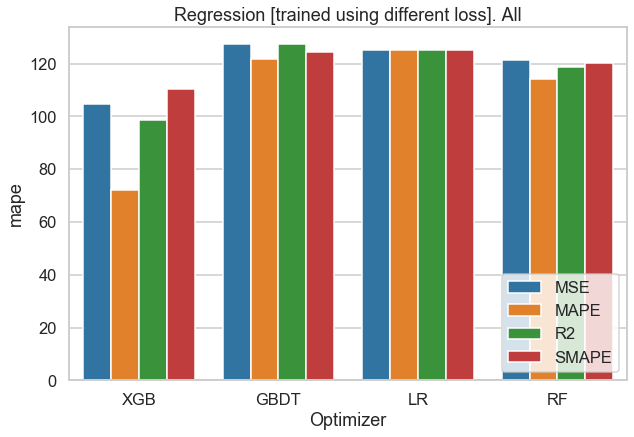

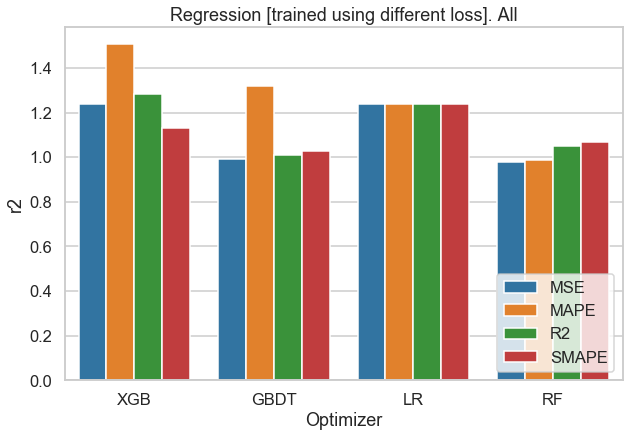

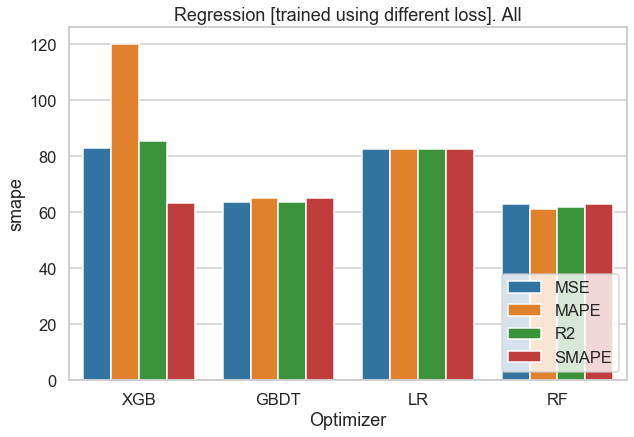

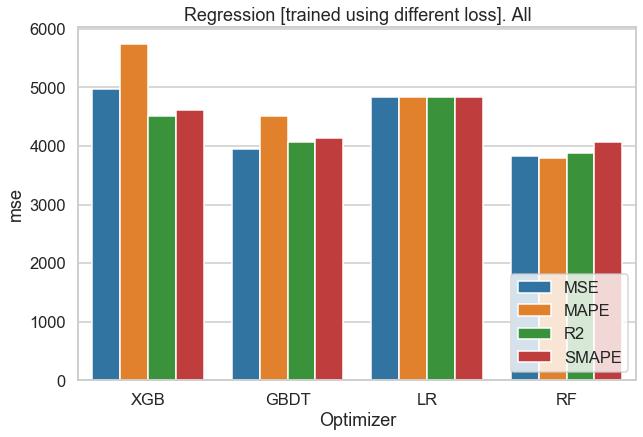

In [53]:
for M in ['mape','r2','smape','mse']:
    
    import seaborn as sns
    sns.set_style("ticks")
    sns.set_style("whitegrid")
    sns.set_context("talk")

    plt.figure(figsize=(10,6.5))
    ax = sns.barplot(x="Optimizer", y=M,hue='Training', data=RES)
    plt.setp(ax.get_legend().get_texts(), fontsize='13')
    plt.legend(loc='lower right')
    plt.title('Regression [trained using different loss]. All')

    plt.show()